In [60]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

import seaborn as sns 

import torch
import torch.nn as nn

import torch.utils.data as data_utils

In [2]:
device = torch.device("cuda:0")

In [3]:
class AE_3HL(nn.Module):  # AE_2HL(input_size, hl1, hl2, hl3)
    def __init__(self, input_size, hl1, hl2, hl3):
        super(AE_3HL, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hl1),
            nn.LeakyReLU(),
            nn.Linear(hl1, hl2),
            nn.LeakyReLU(),
            nn.Linear(hl2, hl3),
            nn.LeakyReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(hl3, hl2),
            nn.LeakyReLU(),
            nn.Linear(hl2, hl1),
            nn.LeakyReLU(),
            nn.Linear(hl1, input_size),
            nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Load data

In [10]:
minibatch_size = 500

In [4]:
train = np.load('/content/train.npz')

In [5]:
train["a"].shape

(1068369, 107)

In [6]:
X_train = torch.from_numpy(train["a"]).float().to(device)

In [7]:
test = np.load("/content/test.npz")

In [8]:
X_test = torch.from_numpy(test["a"]).float().to(device)
y_test = test["b"]

In [16]:
## Initialize model

hl1 = 66
hl2 = 44
hl3 = 22
model = AE_3HL(107, hl1, hl2, hl3)
model = model.to(device)

## Initialize Hyperparameters
learning_rate = 0.001
num_epochs = 100
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=10e-05)

# # Store loss for plotting
history = {}
history['train_loss'] = []
history['test_loss'] = []

In [17]:
# Load data 
train_loader = data_utils.DataLoader(X_train, 
                                     batch_size = minibatch_size, 
                                     shuffle=True)
test_loader = data_utils.DataLoader(X_test, 
                                    batch_size = 1,
                                    shuffle=False)

In [19]:
for epoch in range(num_epochs):
  h = np.array([])
  for data in train_loader:
    # forward
    output = model(data)
    loss = criterion(output, data)
    h = np.append(h, loss.item())

    # backward 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Record loss values 
  mean_loss = np.mean(h)
  print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
  history['train_loss'].append(mean_loss)

torch.save(model.state_dict(), './fraud_detect_model.pth')

epoch [1/100], loss:0.4118
epoch [2/100], loss:0.2625
epoch [3/100], loss:0.2299
epoch [4/100], loss:0.2079
epoch [5/100], loss:0.1895
epoch [6/100], loss:0.1670
epoch [7/100], loss:0.1368
epoch [8/100], loss:0.1207
epoch [9/100], loss:0.1110
epoch [10/100], loss:0.1010
epoch [11/100], loss:0.0947
epoch [12/100], loss:0.0906
epoch [13/100], loss:0.0846
epoch [14/100], loss:0.0768
epoch [15/100], loss:0.0757
epoch [16/100], loss:0.0722
epoch [17/100], loss:0.0731
epoch [18/100], loss:0.0722
epoch [19/100], loss:0.0719
epoch [20/100], loss:0.0701
epoch [21/100], loss:0.0721
epoch [22/100], loss:0.0708
epoch [23/100], loss:0.0755
epoch [24/100], loss:0.0694
epoch [25/100], loss:0.0707
epoch [26/100], loss:0.0718
epoch [27/100], loss:0.0633
epoch [28/100], loss:0.0640
epoch [29/100], loss:0.0630
epoch [30/100], loss:0.0629
epoch [31/100], loss:0.0614
epoch [32/100], loss:0.0585
epoch [33/100], loss:0.0570
epoch [34/100], loss:0.0578
epoch [35/100], loss:0.0581
epoch [36/100], loss:0.0515
e

In [64]:
#history["train_loss"]

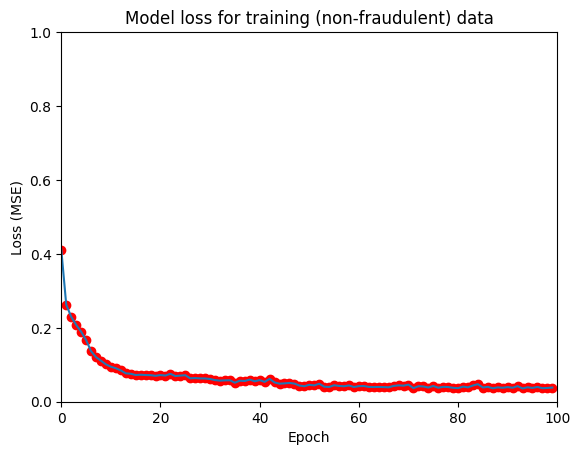

In [29]:
plt.plot(range(num_epochs),history['train_loss'], 'ro', linewidth=0.2)
plt.plot(history['train_loss'])
plt.title('Model loss for training (non-fraudulent) data')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.axis([0,100,0,1])
#plt.legend(['train', 'train_smooth'], loc='upper right');
plt.show()

In [43]:
#training_loss_history_df = pd.DataFrame.from_dict(history)
train_loss_df = pd.DataFrame(history["train_loss"]).to_csv("/content/train_loss.txt", index=False, header=False)

## Predict losses for test data 

In [65]:
model.eval()

AE_3HL(
  (encoder): Sequential(
    (0): Linear(in_features=107, out_features=66, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=66, out_features=44, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=44, out_features=22, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=22, out_features=44, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=44, out_features=66, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=66, out_features=107, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
)

In [71]:
model.eval()

pred_loss_dict = {"loss":[], "True Label": y_test}

with torch.no_grad():
    for data in test_loader:
      sample = model(data)
      loss = criterion(data.to(device), sample)
      pred_loss_dict["loss"].append(loss.item())

In [77]:
#loss_scatter = []
#for i in pred_loss_dict["loss"]:
#  loss_scatter.append((i,i))
#  plt.scatter(*zip(*loss_scatter))
 #plt.axvline(0.3, 0.0, 1)

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7efd3a6a8a60> (for post_execute):


KeyboardInterrupt: ignored

In [74]:
pred_loss_df2 = pd.DataFrame(pred_loss_dict)
pred_loss_df2.to_csv('/content/pred_loss_df2.txt', index=False)

In [44]:
pred_losses = { 'pred_loss' : []}

model.eval()

with torch.no_grad():
    for data in test_loader:
        inputs = data
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        pred_losses['pred_loss'].append(loss)
        
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test

In [33]:
reconstructionErrorDF.head(5)

,pred_loss,Class
0,2.461493e+16,0.0
1,2.018829e+16,0.0
2,2.259030e+16,0.0
3,1.879758e+16,0.0
4,1.395674e+16,0.0


In [63]:
reconstructionErrorDF.to_csv("/content/pred_loss.txt", index=False)

In [34]:
sum(reconstructionErrorDF["Class"])

330.0

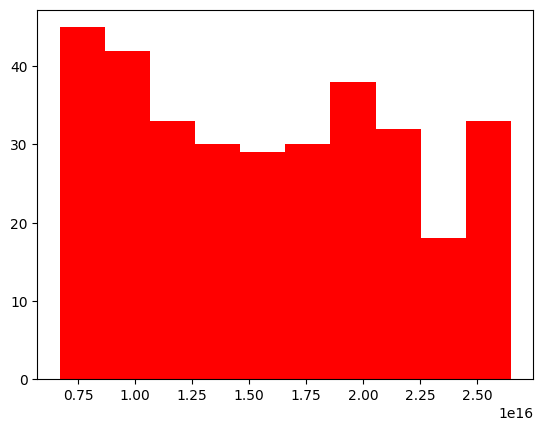

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 1)]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10,color='r')

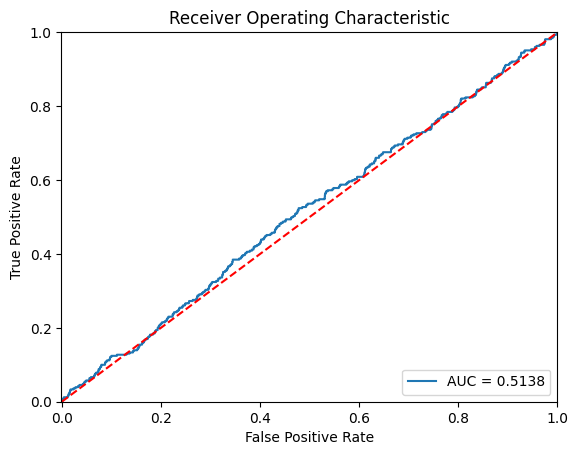

In [50]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

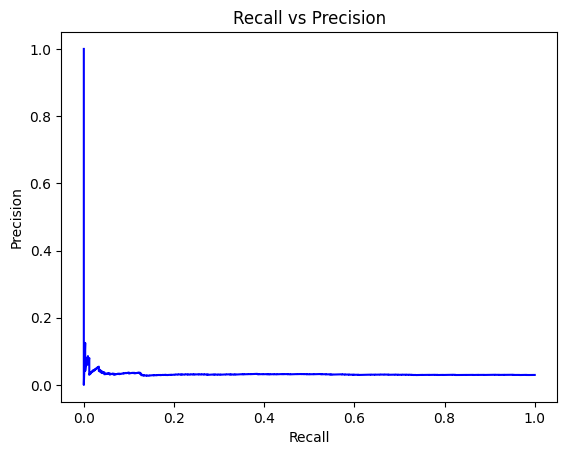

In [51]:
precision, recall, th = precision_recall_curve(
    reconstructionErrorDF.Class, 
    reconstructionErrorDF.pred_loss)

plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

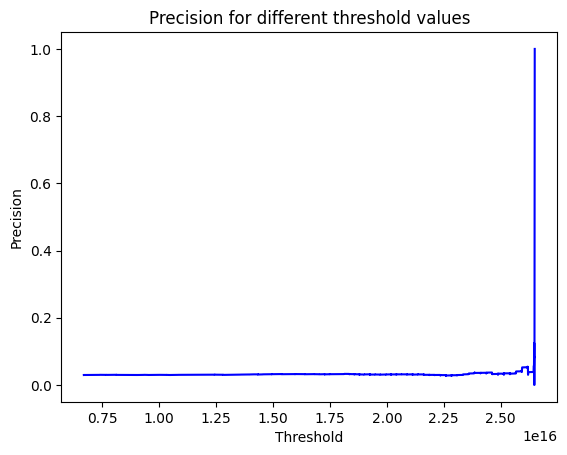

In [52]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

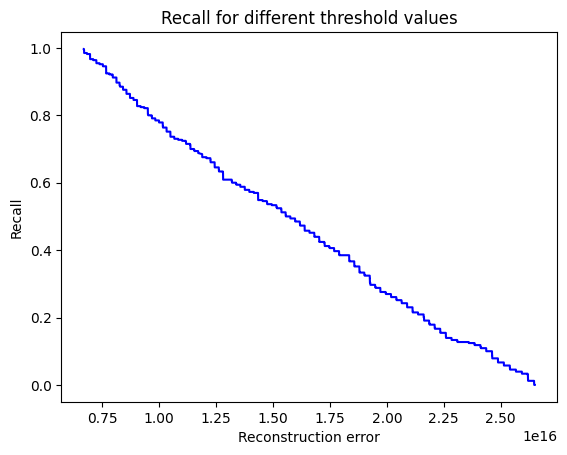

In [53]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

## Predict whether providers are fraudulent 

In [56]:
threshold = 1.5

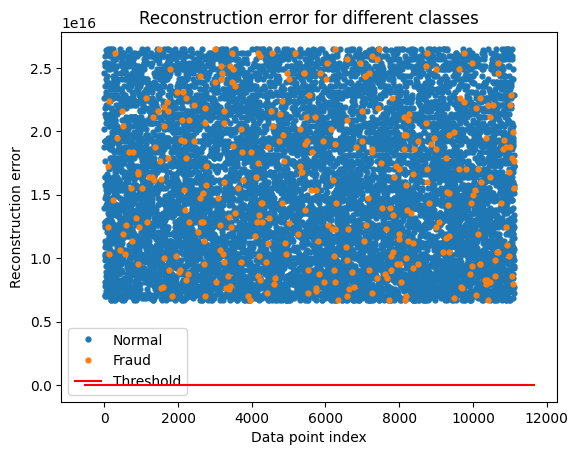

In [58]:
groups = reconstructionErrorDF.groupby('Class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

<ipython-input-62-f5413601b7f7>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'));


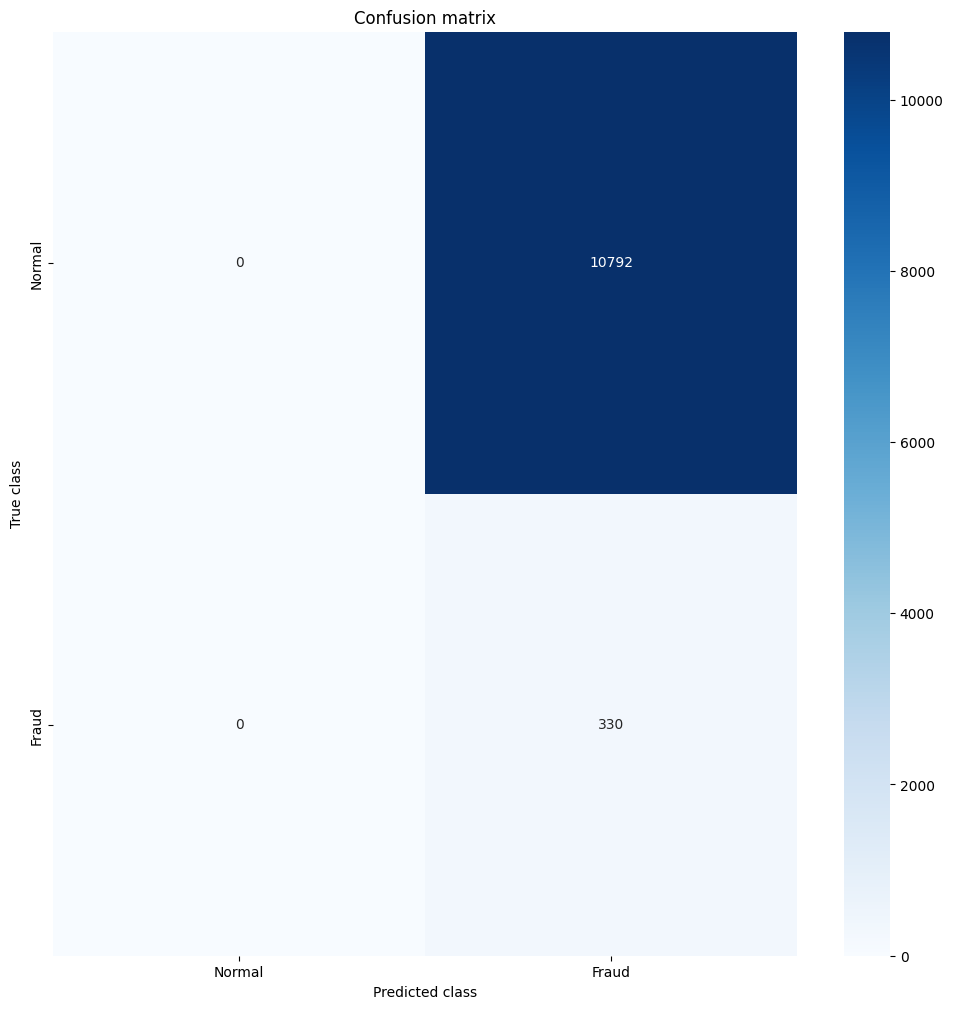

In [62]:
LABELS = ["Normal", "Fraud"]

y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]

conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", 
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()